# Convolutional Neural Networks for Artistic Style Transfer

In [40]:
# Import all of our dependencies
from __future__ import print_function

import time
from PIL import Image
import numpy as np

# Importing the Keras backend, Model class API, and VGG16 convolutional neural network
from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16

# Importing imsave and L-BFGS algorithm for optimization.
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave

## 1. Load and preprocess the content and style images

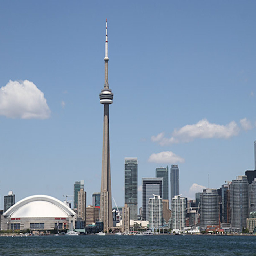

In [41]:
# Set height and width fixed
height = 256
width = 256

# Open the base content image
content_image_path = './base_image.jpg'
content_image = Image.open(content_image_path)
content_image = content_image.resize((height, width))
content_image

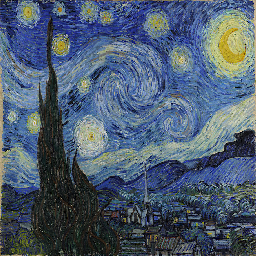

In [42]:
# Open the style transfer image
style_image_path = './style_image.jpg'
style_image = Image.open(style_image_path)
style_image = style_image.resize((height, width))
style_image

### 1.1 Preprocess content and style images

In [43]:
# Turn images into arrays for numerical processing
# Add another dimension so we can concatenate them into a tensor

content_array = np.asarray(content_image, dtype='float32')
content_array = np.expand_dims(content_array, axis=0)
print(content_array.shape)

style_array = np.asarray(style_image, dtype='float32')
style_array = np.expand_dims(style_array, axis=0)
print(style_array.shape)

(1, 256, 256, 3)
(1, 256, 256, 3)


In [44]:
# Massaging the values for RGB, flipping to GBR to match research paper
# meanRGB = [103.939, 116.779, 123.68] 

content_array[:, :, :, 0] -= 103.939
content_array[:, :, :, 1] -= 116.779
content_array[:, :, :, 2] -= 123.68
content_array = content_array[:, :, :, ::-1]

style_array[:, :, :, 0] -= 103.939
style_array[:, :, :, 1] -= 116.779
style_array[:, :, :, 2] -= 123.68
style_array = style_array[:, :, :, ::-1]

### 1.2 Define variables in Keras' backend (TensorFlow graph) 

In [45]:
# Use these arrays to define variables in Keras' backend (TensorFlow graph in this case)
# Placeholder variable to store the combination images

content_image = backend.variable(content_array)
style_image = backend.variable(style_array)
combination_image = backend.placeholder((1, height, width, 3))

In [46]:
# Concatenate all this data into a single tensor for Keras' VGG16

input_tensor = backend.concatenate([content_image, style_image, combination_image], axis=0)

## 2. Reusing a pre-trained model for image classification to define loss functions

In [47]:
# Create the VGG16 model, not including the fully connected layer since this is not a classifier

model = VGG16(input_tensor=input_tensor, weights='imagenet', include_top=False)

In [48]:
# This model has many layers, and Keras has it's own names for these layers. 
# Make a list of these names for reference
# TensorFlow tensors get well-defined shapes since Keras input tensor is concrete

layers = dict([(layer.name, layer.output) for layer in model.layers])
layers

{'block1_conv1': <tf.Tensor 'Relu_26:0' shape=(3, 256, 256, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'Relu_27:0' shape=(3, 256, 256, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'MaxPool_10:0' shape=(3, 128, 128, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'Relu_28:0' shape=(3, 128, 128, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'Relu_29:0' shape=(3, 128, 128, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'MaxPool_11:0' shape=(3, 64, 64, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'Relu_30:0' shape=(3, 64, 64, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'Relu_31:0' shape=(3, 64, 64, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'Relu_32:0' shape=(3, 64, 64, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'MaxPool_12:0' shape=(3, 32, 32, 256) dtype=float32>,
 'block4_conv1': <tf.Tensor 'Relu_33:0' shape=(3, 32, 32, 512) dtype=float32>,
 'block4_conv2': <tf.Tensor 'Relu_34:0' shape=(3, 32, 32, 512) dtype=float32>,
 'block4_conv3': <tf.Tensor 'Relu_35:0'

### 2.1 Defining scalar weights for content, style, and total variation in the combination image

In [49]:
# IMPORTANT: The style-transfer problem can be posed as an optimization problem, 
# where the loss function we want to minimize can be decomposed into three distinct parts:
# content loss, style loss, total variation loss. Relative importance determined by a set of scalar weights.
# These values make it look aesthetically pleasing

content_weight = 0.025
style_weight = 5.0
total_variation_weight = 1.0

# Now we use the feature spaces provided by specific layers of our model to define these three loss functions.
# Initialize the total loss to 0 and add to it in the stages.

loss = backend.variable(0.)

### 2.2 The content loss function

In [50]:
# The content loss is the Euclidean distance between the feature representations of the content and combination images
def content_loss(content, combination):
    return backend.sum(backend.square(content - combination))

# Draw content from block2_conv2 layer
# Features are stored in the tensor, each image sub-array has its own features
layer_features = layers['block2_conv2']
content_image_features = layer_features[0, :, :, :]
combination_image_features = layer_features[2, :, :, :]

# Loss is defines as the weights multiplied by the value of the content loss function with content_image's
# features and combination_image's features passed in as parameters
loss += content_weight * content_loss(content_image_features, combination_image_features)

### 2.3 The style loss function

In [51]:
# Define a Gram Matrix by reshaping the feature spaces and taking an outer product
def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram

In [52]:
# The style loss is then the (scales, sqaures) Frobenius norm of the difference between
# the Gram matrices of the style and combination images.
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = height * width
    return backend.sum(backend.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

In [53]:
feature_layers = ['block1_conv2', 'block2_conv2', 'block3_conv3', 'block4_conv3', 'block5_conv3']

for layer_name in feature_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_features, combination_features)
    loss += (style_weight / len(feature_layers)) * sl

### 2.4 The total variation loss

In [54]:
# The total variation loss is a regularization term that encourages spatial smoothness
def total_variation_loss(x):
    a = backend.square(x[:, :height-1, :width-1, :] - x[:, 1:, :width-1, :])
    b = backend.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return backend.sum(backend.pow(a + b, 1.25))

loss += total_variation_weight * total_variation_loss(combination_image)

## 3. Define needed gradients and solve the optimization problem

In [55]:
# Setup an optimization problem that solves for a combination image that contains the ocntent of the content image,
# while having the style of the style image.
# Define the gradients of the total loss relative to the combination image.
# Use these gradients to iteratively improve upon the combination image by minimizing the loss.

# Loss with respect to combination image
grads = backend.gradients(loss, combination_image)

In [56]:
# Introduce an Evaluator class that computes loss and gradients in one pass
# while retreiving them via two separate functions, 'loss' and 'grads'.
# This is done because scipy.optimize requres separate functions for loss and gradients, 
# but computing them separately would be inefficient.

outputs = [loss]
outputs += grads
f_outputs = backend.function([combination_image], outputs)

def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()
    

In [57]:
# Ready to solve optimization problem. 
# Combination image begins as a random collection of (valid) pixels. We use the L-BFGS algorithm to iteratively
# improve upon it. Sidenote: L-BGFS is quicker to converge than standard SGD.
# L-BFGS = Broyder-Fletcher-Goldfarb-Shanno algorithm

# Define a uniform distribution of random values ranging from 0 to 255, with a size of (1, height, width, 3).
x = np.random.uniform(0, 255, (1, height, width, 3)) - 128.

# Iteratively optimize upon the combination image by minimizing loss through the L-BFGS-B algorithm
iterations = 10

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    # Optimization function takes in the loss function and gradient in the evaluator as some parameters
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(), fprime=evaluator.grads, maxfun=20)
    
    print('Current loss value:', min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))


Start of iteration 0
Current loss value: 3.179e+10
Iteration 0 completed in 909s
Start of iteration 1
Current loss value: 1.36723e+10
Iteration 1 completed in 854s
Start of iteration 2
Current loss value: 1.05672e+10
Iteration 2 completed in 924s
Start of iteration 3
Current loss value: 9.14238e+09
Iteration 3 completed in 1216s
Start of iteration 4
Current loss value: 8.33303e+09
Iteration 4 completed in 1059s
Start of iteration 5
Current loss value: 7.97063e+09
Iteration 5 completed in 1283s
Start of iteration 6
Current loss value: 7.67307e+09
Iteration 6 completed in 1204s
Start of iteration 7
Current loss value: 7.42886e+09
Iteration 7 completed in 1026s
Start of iteration 8
Current loss value: 7.29395e+09
Iteration 8 completed in 882s
Start of iteration 9
Current loss value: 7.16734e+09
Iteration 9 completed in 907s


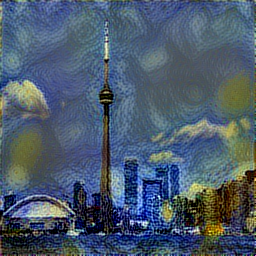

In [58]:
# Reshaping and adjusting the new array

x = x.reshape((height, width, 3))
x = x[:, :, ::-1]
x[:, :, 0] += 103.939
x[:, :, 1] += 116.779
x[:, :, 2] += 123.68

# Clip x to the parameters of maximum value allowed = 255 and minimum value allowed = 0
x = np.clip(x, 0, 255).astype('uint8')

# Generate an image from the array

Image.fromarray(x)
